## Định nghĩa các thư viện cần thiết và kết nối đến drive

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/cv_project/close-price-stock-prediction/data'

/content/drive/MyDrive/cv_project/close-price-stock-prediction/data


## Xem và chuẩn hóa dữ liệu

In [36]:
df = pd.read_csv('data.csv')
df.head(20)

,Date,Close_Price
0,28-02-2023,102.37
1,27-02-2023,102.37
2,24-02-2023,103.52
3,23-02-2023,106.39
4,22-02-2023,106.45
5,21-02-2023,109.27
6,20-02-2023,105.82
7,17-02-2023,106.39
8,16-02-2023,106.11
9,15-02-2023,106.39


In [37]:
df.shape

(1000, 2)

In [38]:
df.describe()

,Close_Price
count,1000.00000
mean,115.07860
std,5.46433
min,102.37000
25%,112.19500
50%,115.86000
75%,119.66250
max,123.53000


In [39]:
 df.isna().sum()

Date           0
Close_Price    0
dtype: int64

In [40]:
year_list_stock = [2019, 2020, 2021, 2022, 2023]
for year in year_list_stock:
  df['Date'] = df['Date'].str.replace('-'+str(year), '/'+str(year))

for month in range(1, 10):
  df['Date'] = df['Date'].str.replace('-0'+str(month), '/'+str(month))

for month in range(10, 13):
  df['Date'] = df['Date'].str.replace('-'+str(month), '/'+str(month))

df.head(20)

,Date,Close_Price
0,28/2/2023,102.37
1,27/2/2023,102.37
2,24/2/2023,103.52
3,23/2/2023,106.39
4,22/2/2023,106.45
5,21/2/2023,109.27
6,20/2/2023,105.82
7,17/2/2023,106.39
8,16/2/2023,106.11
9,15/2/2023,106.39


In [41]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values('Date', inplace=True)
df.head(5)

,Date,Close_Price
999,2019-03-01,109.04
998,2019-03-04,111.04
997,2019-03-05,111.21
996,2019-03-06,114.75
995,2019-03-07,112.46


## Trực quan hóa dữ liệu

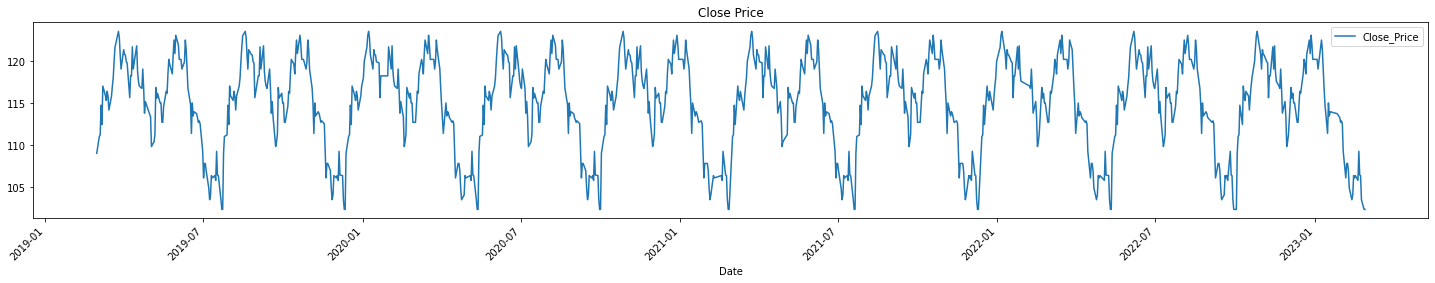

In [42]:
df.plot(x='Date', y='Close_Price', kind='line', rot=45, legend=True, 
        title='Close Price', xlabel='Date', fontsize=10, figsize=(25,4));

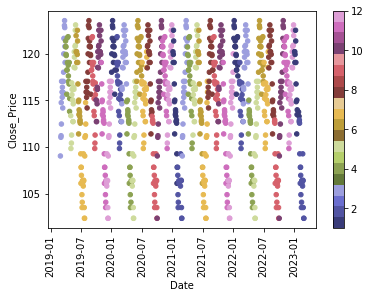

In [43]:
df.plot(x='Date', y='Close_Price', kind='scatter', rot=90, c=df['Date'].dt.month, colormap='tab20b', sharex=False);

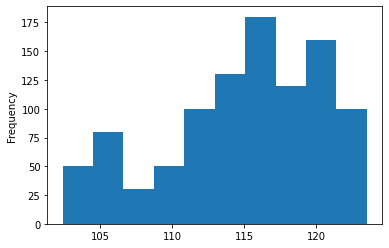

In [44]:
df["Close_Price"].plot(kind = 'hist');

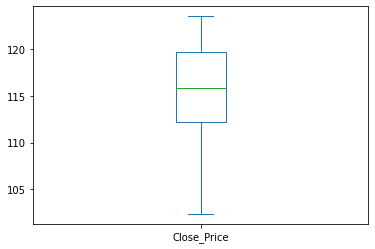

In [45]:
df.plot.box();

## Xây dựng, huấn luyện và dự đoán giá đóng cửa dựa vào mô hình LSTM

In [46]:
train_data = df.iloc[200:, 1:2].values
print(train_data.shape)

(800, 1)


In [47]:
test_data = df.iloc[:200, 1:2].values
print(test_data.shape)

(200, 1)


In [48]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_train_data

array([[0.31521739],
       [0.40973535],
       [0.41776938],
       [0.58506616],
       [0.4768431 ],
       [0.69281664],
       [0.6389414 ],
       [0.61200378],
       [0.66304348],
       [0.63610586],
       [0.55812854],
       [0.63610586],
       [0.69281664],
       [0.73913043],
       [0.83175803],
       [0.91020794],
       [0.97542533],
       [1.        ],
       [0.96455577],
       [0.86956522],
       [0.78827977],
       [0.89697543],
       [0.86956522],
       [0.86672968],
       [0.8289225 ],
       [0.82325142],
       [0.62759924],
       [0.75      ],
       [0.75      ],
       [0.91304348],
       [0.78827977],
       [0.91871456],
       [0.77457467],
       [0.72022684],
       [0.69281664],
       [0.67958412],
       [0.78827977],
       [0.68194707],
       [0.54064272],
       [0.60586011],
       [0.51890359],
       [0.35302457],
       [0.38043478],
       [0.4210775 ],
       [0.68478261],
       [0.62523629],
       [0.65217391],
       [0.597

In [49]:
X_train = []
y_train = []
for i in range(100, len(scaled_train_data)):
  X_train.append(scaled_train_data[i-100:i, 0])
  y_train.append(scaled_train_data[i, 0])
X_train = np.array(X_train)
y_train = np.array(y_train)

In [53]:
print(X_train.shape)
print(y_train.shape)

(700, 100, 1)
(700,)


In [54]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(700, 100, 1)

In [55]:
model = Sequential([
    LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)),
    Dropout(0.2),

    LSTM(units = 50, return_sequences = True),
    Dropout(0.2),

    LSTM(units = 50, return_sequences = True),
    Dropout(0.2),

    LSTM(units = 50),
    Dropout(0.2),

    Dense(units = 1)
])

In [56]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
22/22 [==============================] - 11s 23ms/step - loss: 0.1288
Epoch 2/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0605
Epoch 3/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0388
Epoch 4/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0298
Epoch 5/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0265
Epoch 6/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0233
Epoch 7/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0218
Epoch 8/100
22/22 [==============================] - 0s 16ms/step - loss: 0.0217
Epoch 9/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0201
Epoch 10/100
22/22 [==============================] - 1s 28ms/step - loss: 0.0177
Epoch 11/100
22/22 [==============================] - 1s 29ms/step - loss: 0.0189
Epoch 12/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0182
Epoch 13/100
22/22 [====

In [61]:
scaled_test_data = scaler.fit_transform(test_data)
scaled_test_data

array([[0.31521739],
       [0.40973535],
       [0.41776938],
       [0.58506616],
       [0.4768431 ],
       [0.69281664],
       [0.6389414 ],
       [0.61200378],
       [0.66304348],
       [0.63610586],
       [0.55812854],
       [0.63610586],
       [0.69281664],
       [0.73913043],
       [0.83175803],
       [0.91020794],
       [0.97542533],
       [1.        ],
       [0.96455577],
       [0.86956522],
       [0.78827977],
       [0.89697543],
       [0.86956522],
       [0.86672968],
       [0.8289225 ],
       [0.82325142],
       [0.62759924],
       [0.75      ],
       [0.75      ],
       [0.91304348],
       [0.78827977],
       [0.91871456],
       [0.77457467],
       [0.72022684],
       [0.69281664],
       [0.67958412],
       [0.78827977],
       [0.68194707],
       [0.54064272],
       [0.60586011],
       [0.51890359],
       [0.35302457],
       [0.38043478],
       [0.4210775 ],
       [0.68478261],
       [0.62523629],
       [0.65217391],
       [0.597

In [62]:
scaled_test_data = np.array(scaled_test_data)
print(scaled_test_data.shape)

(200, 1)


In [63]:
X_test = []
for i in range(100, 300):
  X_test.append(scaled_train_data[i-100:i, 0])
X_test = np.array(X_test)

In [64]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(200, 100, 1)

In [65]:
predict = model.predict(X_test)
predict = scaler.inverse_transform(predict)

7/7 [==============================] - 2s 12ms/step


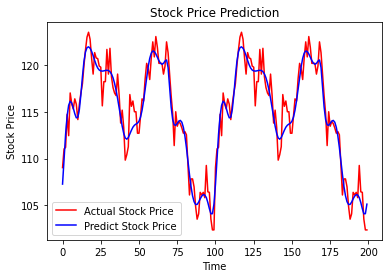

In [68]:
plt.plot(test_data, color='red', label='Actual Stock Price')
plt.plot(predict, color='blue', label='Predict Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend();